In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm

import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 

You measure the position of a quasar $N$ times with the *same* telescope i.e. errors are homoscedastic. Let's say the underlying process is Gaussian, the true position is $\mu = 1$ (in suitable units), and the erorrs are $\sigma=0.2$

### Part 1

- Generate fake measurements. Treat each of these observations as an estimate of the true distribution. So we'll center a Gaussian (with the known $\sigma$) at each point. This is the probability of each data point, $p(x_i|\mu,\sigma)$.
- Plot each of the individual likelihoods separately.  Also plot their product (i.e. the likelihood of the dataset $\{x_i\}$). Make sure the x grid has enough points.
- Just read off the maximum likelihood solution (e.g. using `np.argsort`) 
- Compare it with the MLE estimator derived above

### Part 2

Check the Fisher matrix error estimate makes sense
- do a rough $2^\mathrm{nd}$ order differentation of our log-likelihood function with `np.diff`, 
- divide through by our $\Delta \theta^2$ to get the correct normalization, 
- multiply by $-1$, 
- then take the square root.
- Compare with the Fisher matrix error derived above
- Plot a Gaussian at the measured $\mu$ with this error as the scale to see if it matches the numerical likelihood distribution. (The normalization won't be captured, you can rescale it as you like to check it agrees) 

### Part 3

Let's make our model more realistic. Our $N$ measurements were taken in different nights, where the sky behaved differently (i.e. errors are heteoscedastic). Let's assume that each measurment has a $\sigma_i$ that is normally distribured with mean $0.2$ and standard deviation $0.05$

- Generalize your code from above to this case

# Code

## 1) Homoscedastic Errors

### MLE estimator

In [2]:
N = 10 # Dataset size
mu = 1
sigma = 0.2

data = np.random.normal(mu, sigma, N)
data

array([1.05652768, 0.91355043, 1.10770784, 1.24687807, 0.89432971,
       0.81127229, 0.92104613, 0.94779552, 0.74891432, 1.03643817])

100%|██████████| 10/10 [00:00<00:00, 370.37it/s]


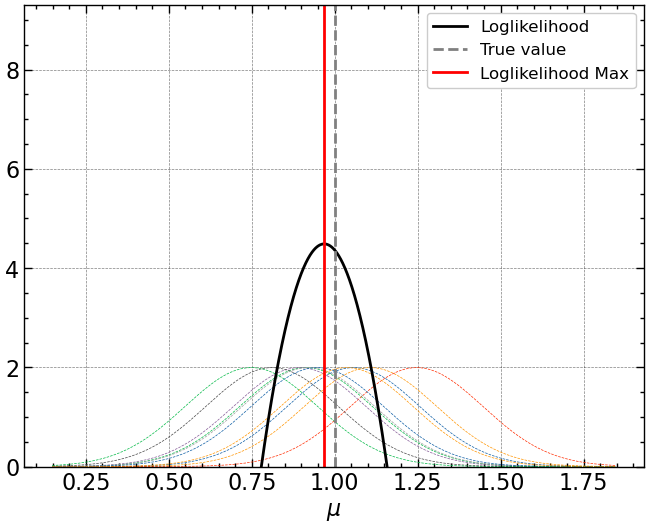

In [3]:
x_min = np.min(data)-3*sigma
x_max = np.max(data)+3*sigma
x_dense = np.linspace(x_min, x_max, 10000)

for i in tqdm(range(len(data))):
    dist = scipy.stats.norm(data[i], sigma)
    dist_eval = dist.pdf(x_dense)
    plt.plot(x_dense, dist_eval, ls='--', lw=0.5)
    
    if i==0 : loglikelihood = np.log(dist_eval)
    else : loglikelihood = loglikelihood + np.log(dist_eval)
    
plt.plot(x_dense, loglikelihood, c='black', label='Loglikelihood')

plt.axvline(mu, ls='--', c='grey', label='True value')

loglikelihood_max = x_dense[np.argsort(loglikelihood)[-1]]
plt.axvline(loglikelihood_max, ls='-', c='red', label='Loglikelihood Max')

plt.xlabel('$\mu$')
plt.ylim(0)
plt.legend(fontsize=12)

Let's check the result by computing the MLE estimator in the case of homoscedastic errors:
$$\hat \mu = \frac{1}{N}\sum_{i=1}^N x_i \pm \frac{\sigma}{\sqrt{N}}$$

In [4]:
MLE_est = np.array([np.mean(data), sigma/np.sqrt(N)])
print(f'Likelihood max = {loglikelihood_max:.6f}')
print(f'MLE estimator = {MLE_est[0]:.6f} +- {MLE_est[1]:.6f}')

Likelihood max = 0.968434
MLE estimator = 0.968446 +- 0.063246


### Fisher matrix error

Compute the first derivative

In [5]:
loglikelihood_firstD = np.diff(loglikelihood)/np.diff(x_dense)[0]

Compute the second derivative

In [6]:
loglikelihood_secondD = np.diff(loglikelihood_firstD)/np.diff(x_dense)[0]

Evaluate it in the MLE estimator

In [7]:
loglikelihood_secondD_MLE = loglikelihood_secondD[np.argsort(loglikelihood)[-1]]
loglikelihood_secondD_MLE

-249.99999995348747

Compute the Fisher matrix error and compare it with the one analytically derived

In [8]:
fisher_error = np.sqrt(-1/loglikelihood_secondD_MLE)
print(f'Fisher matrix error = {fisher_error:.6f}')
print(f'MLE error = {MLE_est[1]:.6f}')

Fisher matrix error = 0.063246
MLE error = 0.063246


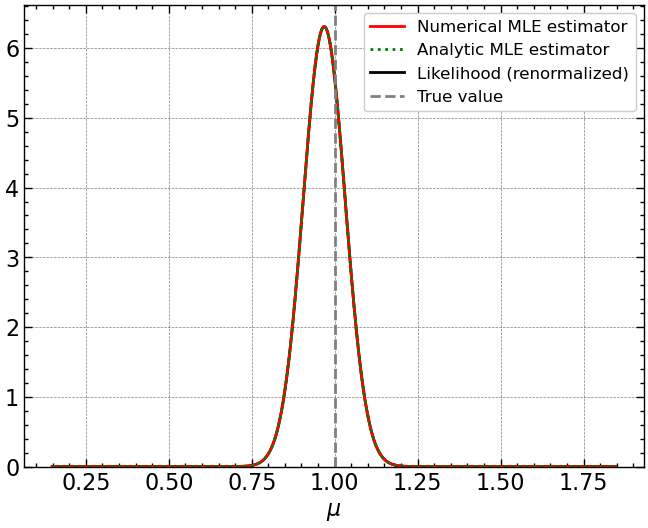

In [9]:
dist = scipy.stats.norm(loglikelihood_max, fisher_error)
plt.plot(x_dense, dist.pdf(x_dense), ls='-', c='red', label='Numerical MLE estimator')

dist = scipy.stats.norm(MLE_est[0], MLE_est[1])
plt.plot(x_dense, dist.pdf(x_dense), ls=':', c='green', label='Analytic MLE estimator')

renorm_factor = np.max(dist.pdf(x_dense))/np.exp(np.max(loglikelihood))

plt.plot(x_dense, renorm_factor*np.exp(loglikelihood), c='black', label='Likelihood (renormalized)', zorder=0)
plt.axvline(mu, ls='--', c='grey', label='True value')

plt.xlabel('$\mu$')
plt.ylim(0)
plt.legend(fontsize=12)

## 2) Heteroscedastic Errors

In [10]:
sigma = np.random.normal(0.2, 0.05, N)
sigma

array([0.13628351, 0.15248167, 0.19505786, 0.14775649, 0.20418789,
       0.23649995, 0.21464254, 0.16998568, 0.19855005, 0.12068083])

In [11]:
data = np.zeros(N)

for i in range(N):
    data[i] = np.random.normal(mu, sigma[i])
    
data

array([1.02421703, 1.21627628, 0.89938132, 0.87075047, 1.06199119,
       0.77392393, 1.00064573, 1.06296706, 0.72997676, 1.03805831])

100%|██████████| 10/10 [00:00<00:00, 625.00it/s]


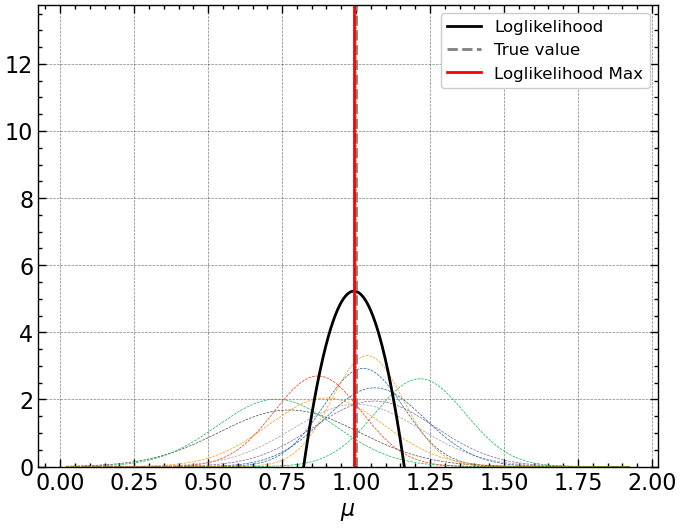

In [12]:
x_min = np.min(data)-3*np.max(sigma)
x_max = np.max(data)+3*np.max(sigma)
x_dense = np.linspace(x_min, x_max, 1000)

for i in tqdm(range(len(data))):
    dist = scipy.stats.norm(data[i], sigma[i])
    dist_eval = dist.pdf(x_dense)
    plt.plot(x_dense, dist_eval, ls='--', lw=0.5)
    
    if i==0 : loglikelihood = np.log(dist_eval)
    else : loglikelihood = loglikelihood + np.log(dist_eval)
    
plt.plot(x_dense, loglikelihood, c='black', label='Loglikelihood')

plt.axvline(mu, ls='--', c='grey', label='True value')

loglikelihood_max = x_dense[np.argsort(loglikelihood)[-1]]
plt.axvline(loglikelihood_max, ls='-', c='red', label='Loglikelihood Max')

plt.xlabel('$\mu$')
plt.ylim(0)
plt.legend(fontsize=12)

Let's check the result by computing the MLE estimator in the case of heteroscedastic errors:
$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)} \pm \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}$$ 

In [13]:
MLE_est = np.array([np.sum(data/sigma**2)/np.sum(1/sigma**2), np.sqrt(1/np.sum(1/sigma**2))])
print(f'Likelihood max = {loglikelihood_max:.6f}')
print(f'MLE estimator = {MLE_est[0]:.6f} +- {MLE_est[1]:.6f}')

Likelihood max = 0.993152
MLE estimator = 0.992919 +- 0.052621


<font color='red'>WATCH OUT!!!</font>

In [14]:
print(f'{np.sum(data/sigma**2)/np.sum(1/sigma**2)} = {np.average(data, weights=1/sigma**2)} != {np.average(data, weights=sigma)}')

0.9929191923211093 = 0.9929191923211093 != 0.9541515641228725


### Fisher matrix error

Compute the first derivative

In [15]:
loglikelihood_firstD = np.diff(loglikelihood)/np.diff(x_dense)[0]

Compute the second derivative

In [16]:
loglikelihood_secondD = np.diff(loglikelihood_firstD)/np.diff(x_dense)[0]

Evaluate it in the MLE estimator

In [17]:
loglikelihood_secondD_MLE = loglikelihood_secondD[np.argsort(loglikelihood)[-1]]
loglikelihood_secondD_MLE

-361.1445267307833

Compute the Fisher matrix error and compare it with the one analytically derived

In [18]:
fisher_error = np.sqrt(-1/loglikelihood_secondD_MLE)
print(f'Fisher matrix error = {fisher_error:.6f}')
print(f'MLE error = {MLE_est[1]:.6f}')

Fisher matrix error = 0.052621
MLE error = 0.052621


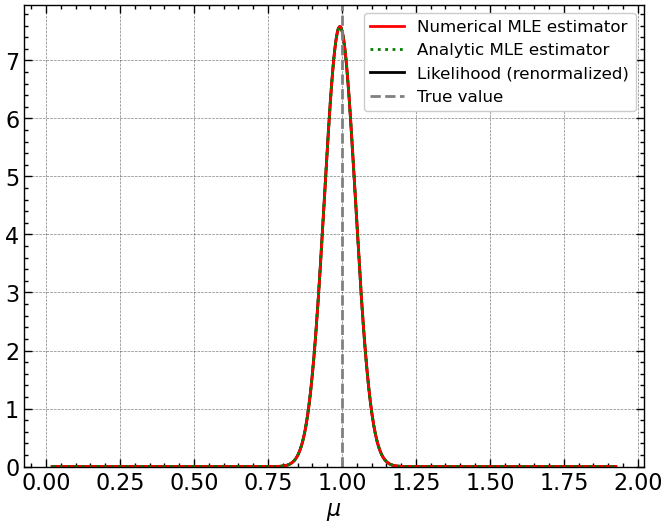

In [19]:
dist = scipy.stats.norm(loglikelihood_max, fisher_error)
plt.plot(x_dense, dist.pdf(x_dense), ls='-', c='red', label='Numerical MLE estimator')

dist = scipy.stats.norm(MLE_est[0], MLE_est[1])
plt.plot(x_dense, dist.pdf(x_dense), ls=':', c='green', label='Analytic MLE estimator')

renorm_factor = np.max(dist.pdf(x_dense))/np.exp(np.max(loglikelihood))

plt.plot(x_dense, renorm_factor*np.exp(loglikelihood), c='black', label='Likelihood (renormalized)', zorder=0)
plt.axvline(mu, ls='--', c='grey', label='True value')

plt.xlabel('$\mu$')
plt.ylim(0)
plt.legend(fontsize=12)